# GDAL

<img src=http://gdal.org/gdalicon.png align=left> GDAL é uma biblioteca para tradução de formatos de dados geográficos distribuída pela _Open Source Geospatial Foundation_ (**osgeo**) sob a licença X/MIT estilo Open Source. 

GDAL significa _Geospatial Data Abstraction Library_ (Biblioteca de Abstrações de Dados Geoespaciais), e permite aos usuários manipular <a href=http://gdal.org/formats_list.html>142 formatos de arquivos raster e 84 formatos de arquivos vetoriais</a>.

As aplicações que a utilizam acessam todos os formatos suportados pela biblioteca através de um único modelo de dados abstrato. A biblioteca GDAL também conta com uma variadade de programas utilitários de linha de comando para a tradução de formatos bem como uma série de outras funções. 

_Tradicionalmente a biblioteca GDAL referia-se a dados Raster enquanto que OGR referia-se a dados Vetorias (Simple Features). Mas a partir da versão 2.0 as duas partes estão mais integradas._

Página principal: http://www.gdal.org
Documentação oficial para Python: http://gdal.org/python/

In [1]:
# importar biblioteca
from osgeo import gdal

# importar constantes
from gdalconst import *

# informar o uso de exceções
gdal.UseExceptions()

# mostrar versão instalada
print (gdal.__version__)

2.2.2


## Raster

<img src=https://upload.wikimedia.org/wikipedia/commons/thumb/8/8f/Hark_%28rake%29.jpg/100px-Hark_%28rake%29.jpg align=right width=50>The word **raster** has its origins in the Latin _rastrum_ (a rake, _ancinho_), which is derived from radere (to scrape, _raspar/arranhar_). It originates from the raster scan video monitors, which paint the image line by line by magnetically steering a focused electron beam. 

By association, it can also refer to a rectangular grid of pixels. The word rastrum is now used to refer to a device for drawing musical staff lines.

Fonte: <a href=https://en.wikipedia.org/wiki/Raster_graphics#Etymology>Wikipedia</a>

## Estrutura de armazenamento

Um raster pode ser armazenado de diferentes formas, uma delas é através do armazenamento individual, um raster independente para cada banda. Neste caso, cada arquivo possui metadados (sistema de coordenadas, limites geográficos), independentes. Veja por exemplo as imagens do CBERS-2B:
  * CBERS_2B_CCD1XS_20080223_148_120_L2_BAND2.tif (raster 1)
  * CBERS_2B_CCD1XS_20080223_148_120_L2_BAND3.tif (raster 0)
  * CBERS_2B_CCD1XS_20080223_148_120_L2_BAND4.tif (raster 2)

_A associação de cores a seguir é apenas ilustrativa._
<img src=http://www.dpi.inpe.br/terralib5/wiki/lib/exe/fetch.php?w=300&tok=779221&media=wiki:designimplementation:raster:one-band-per-raster.png>

Outra maneira é armazenar diversas bandas no mesmo arquivo. Neste caso, o conjunto de metadados vale para todas as bandas. Por exemplo, imagens do WorldView-2 podem ser obtidas em um único arquivo GeoTIFF:
  * WV2_MUL_2_BLUE (band 2)
  * WV2_MUL_3_GREEN (band 1)
  * WV2_MUL_5_RED (band 0)

<img src=http://www.dpi.inpe.br/terralib5/wiki/lib/exe/fetch.php?w=150&tok=a8aa26&media=wiki:designimplementation:raster:multiple-bands-per-raster.png>

**Obs.:** Um raster pode ter qualquer número de bandas, desde que suportado pelo seu formato.

## Grade
A grade (_grid_) contém metadados relacionados às imagens, incluindo:
  * limites geográficos
  * sistema de referência espacial
  * número de linhas/colunas
  * 6 coeficientes para transformação afim:
    * [0] is the x coordinate of the upper left cell in raster
    * [1] is the width of the elements in the raster
    * [2] is the element rotation in x, is set to 0 if a north up raster
    * [3] is the y coordinate of the upper left cell in raster
    * [4] is the element rotation in y, is set to 0 if a north up raster
    * [5] is the height of the elements in the raster (negative)

## Banda
A banda (_band_) é que contém as informações dos níveis digitais das imagens, além de outras propriedades:
  * NoDataValue
  * Minimum/Maximum
  * Histogram
  * Tipo de dados
  * Estatísticas (média/desvio padrão)
  * matriz de pixels
  

## Abertura de um arquivo raster

A função **open** é utilizada para abrir um conjunto de dados (*dataset*), que exige dois parâmetros:
  * **Nome do Arquivo**: caminho e nome completo
  * **Forma de Acesso**: informação se a abertura será apenas para leitura ou também alteração no arquivo (*GA_ReadOnly* ou *GA_Update*).

In [2]:
# criar o dataset abrindo o arquivo para leitura
filename = "./raster/crop_rapideye.tif"
dataset = gdal.Open(filename, GA_ReadOnly)

# fechar o dataset e liberar memória
dataset = None 

### Dica de boa prática de desenvolvimento
Ao efetuar o comando de abertura de um arquivo, pode ocorrer uma mensagem de erro caso exista falha na localização do arquivo ou ainda se o mesmo estiver corrompido. Por isso uma boa prática é sempre fazer um teste utilizando _try/except_, conforme mostrado no exemplo abaixo.

In [3]:
# biblioteca de funções relacionadas ao sistema
# sys: System-specific parameters and functions
import sys

filename_erro = "teste/" + filename
print ("Tentar abrir", filename_erro)

try:
    dataset = gdal.Open(filename_erro, GA_ReadOnly)
    print ("Arquivo aberto com sucesso!")
except:
    print("Erro na abertura do arquivo!")
    
print ("Tentar abrir" + filename)
try:
    dataset = gdal.Open(filename, GA_ReadOnly)
    print ("Arquivo aberto com sucesso!")
except:
    print("Erro na abertura do arquivo!")

Tentar abrir teste/./raster/crop_rapideye.tif
Erro na abertura do arquivo!
Tentar abrir./raster/crop_rapideye.tif
Arquivo aberto com sucesso!


## Manipulação do DATASET

Um dataset de um raster pode conter uma ou mais bandas (ou camadas de dados) que podem estar representando variações de canais espectrais de um mesmo sensor ou de uma mesma variável ao longo do tempo. Sempre, cada banda de um dataset possui as mesmas dimensões em X e Y (colunas e linhas), e com isto recobrem a mesma extensão espacial.

In [4]:
geotransform = dataset.GetGeoTransform()
print (geotransform)

(505900.0, 5.0, 0.0, 7858335.0, 0.0, -5.0)


Como pode ser observado na listagem acima o método **GetGeoTransform** retorna uma tupla com os respectivos valores citados anteriormente, referentes à transformação de georreferenciamento do dataset utilizado como exemplo.

In [5]:
# [0] is the x coordinate of the upper left cell in raster
# [1] is the width of the elements in the raster
# [2] is the element rotation in x, is set to 0 if a north up raster
# [3] is the y coordinate of the upper left cell in raster
# [4] is the element rotation in y, is set to 0 if a north up raster
# [5] is the height of the elements in the raster (negative)

latitude = geotransform[3]
longitude = geotransform[0]
resolucao_x = geotransform[1]
resolucao_y = -geotransform[5]

print ("Latitude inicial do dataset:", latitude)
print ("Longitude inicial do dataset:", longitude)
print ("Resolução (x) do dataset:", resolucao_x)
print ("Resolução (y) do dataset:", resolucao_y)

Latitude inicial do dataset: 7858335.0
Longitude inicial do dataset: 505900.0
Resolução (x) do dataset: 5.0
Resolução (y) do dataset: 5.0


Para saber qual o sistema de coordenadas neste dataset, deve ser utilizado o método **GetProjectionRef** que retorna uma descrição em formato _WKT (Well-Known Text)_, que é uma linguagem de marcação de texto utilizada para representar um sistema de referência espacial dos objetos geográficos e a transformação entre sistemas de coordenadas.

In [6]:
print (dataset.GetProjectionRef())

PROJCS["WGS 84 / UTM zone 21S",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-57],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",10000000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32721"]]


Um Sistema de Referência Espacial _(Spatial Reference System - SRS)_ ou sistema de coordenadas de referência (_Coordinate Reference System - CRS_) pode ser um sistema local, regional ou global baseado usado para localizar objetos geográficos.

Para Permitir uma maior interoperabilidade e facilidade na utilização, vários sistemas de informação geográfica fazem referência a um Sistema de Referência Espacial indicando apenas um número inteiro que representa o **SRID** ou códigos **EPSG** que são definidos pela Associação Internacional de Produtores de Petróleo e Gás.

Para identificar os códigos corretos para o sistema de referência espacial do seu interesse pode ser utilizado os seguintes portais:

http://epsg.io

http://spatialreference.org 

## Dimensões do arquivo
Para saber o número de linhas e colunas do dataset que está sendo utilizado devemos utilizar o método **RasterYSize** e **RasterXSize** conforme pode ser visto no **exemplo**:

In [7]:
# número de linhas e colunas
linhas = dataset.RasterYSize
colunas = dataset.RasterXSize

print ("Número de linhas:", linhas)
print ("Número de colunas:", colunas)

Número de linhas: 1446
Número de colunas: 2322


## Leitura dos dados de uma banda do arquivo

Depois da abertura do arquivo e da geração do dataset, a leitura de cada banda deve ser realizada individualmente e de forma repetida iniciando a partir da banda 1 até o total de bandas de cada arquivo, que pode ser obtido por meio do método **RasterCount**

In [8]:
# quantidade de bandas
bandas = dataset.RasterCount

print ("Número de bandas:", bandas)

# no caso da imagem RapidEye, as bandas 5
# e 3 correspondem às bandas NIR e RED
banda_nir = dataset.GetRasterBand(5)
banda_red = dataset.GetRasterBand(3)

Número de bandas: 5


Uma propriedade importante para manipulação correta dos dados é conferir o tipo do dado armazenado e que acaba de ser lido a partir da banda.

In [9]:
print ("Tipos de dados:")
print (" - banda NIR:", gdal.GetDataTypeName(banda_nir.DataType))
print (" - banda RED:", gdal.GetDataTypeName(banda_red.DataType))

Tipos de dados:
 - banda NIR: UInt16
 - banda RED: UInt16


É possível saber qual o valor mínimo e máximo de uma banda utilizando o método da banda **ComputeRasterMinMax**

In [10]:
(menor_valor, maior_valor) = banda_red.ComputeRasterMinMax()
print("Menor valor de RED:", menor_valor)
print("Maior valor de RED:", maior_valor)

Menor valor de RED: 0.0
Maior valor de RED: 20693.0


## Exercício: Escreva um programa para apresentar os valores mínimos e máximos de todas as bandas do raster de trabalho

In [14]:
for i in range(bandas):
    print ("Mínimos e máximos da banda", i + 1)
    print (dataset.GetRasterBand(i + 1).ComputeRasterMinMax())

Mínimos e máximos da banda 1
(0.0, 18559.0)
Mínimos e máximos da banda 2
(0.0, 18851.0)
Mínimos e máximos da banda 3
(0.0, 20693.0)
Mínimos e máximos da banda 4
(0.0, 16055.0)
Mínimos e máximos da banda 5
(0.0, 19273.0)


Depois de criado o objeto banda precisamos ler os dados para iniciar qualquer processamento com estes valores. Uma maneira muito utilizada é manipular os dados matriciais com auxílio da biblioteca **NumPy**, através do método **ReadAsArray** para leitura dos valores gerando uma array multidimensional. Outra informação importante é saber se a matriz que foi gerada com a leitura da banda foi criada com o número de linhas e colunas de forma correta, isto deverá ser feito utlizando o método **shape**

In [25]:
# obtencao dos arrays numpy das bandas
array_red = banda_red.ReadAsArray()
array_nir = banda_nir.ReadAsArray()

# geracao de array derivado das bandas
array_ndvi = (array_nir - array_red) / (array_nir + array_red)

# mostrar dimensoes da matriz de saida
print(array_ndvi.shape)

(1446, 2322)


/home/thales/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


Podemos combinar as bibliotecas **NumPy** e **Matplotlib** para visualizar as matrizes como imagens.

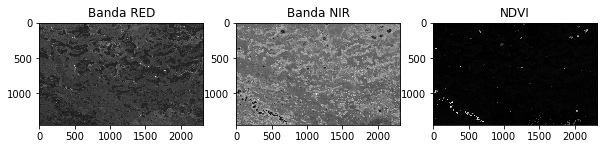

In [27]:
# display dos resultados
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

plt.subplot(131)
plt.title("Banda RED")
plt.imshow(array_red, cmap='gray')

plt.subplot(132)
plt.title("Banda NIR")
plt.imshow(array_nir, cmap='gray')

plt.subplot(133)
plt.title("NDVI")
plt.imshow(array_ndvi, cmap='gray')